In [1]:
!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
!unzip -qq synthetic-data.zip

--2023-10-18 03:52:07--  https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/l2ul3upj7dkv4ou/synthetic-data.zip [following]
--2023-10-18 03:52:08--  https://www.dropbox.com/s/raw/l2ul3upj7dkv4ou/synthetic-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc20b61cf6692ca76389209f1be0.dl.dropboxusercontent.com/cd/0/inline/CFzAgYFLSNKYpxc1jy532myvAvlu6SWxc4JVfGbZ3pE7owPpMSlPCCTtKPchXG6NhBJmg9UE7K5Vou6C4PA3olNfN78pZ8ZrAjn_IsPOP4LDE-NrMGt1VGUjQEdN2tvzfCmFN6uyFRCPZ6NzcE2k655V/file# [following]
--2023-10-18 03:52:08--  https://uc20b61cf6692ca76389209f1be0.dl.dropboxusercontent.com/cd/0/inline/CFzAgYFLSNKYpxc1jy532myvAvlu6SWxc4JVfGbZ3pE7owPpMSlPCCTtKPchXG6NhBJmg9UE7K5Vou6C4PA3

In [2]:
!pip install torch_snippets torch_summary editdistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 15.9 MB/s eta 

In [3]:
from torch_snippets import *
from torchsummary import summary
import editdistance

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fname2label = lambda fname: stem(fname).split('@')[0]
images = Glob('synthetic-data')

In [5]:
vocab = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
B,T,V = 64, 32, len(vocab)
H,W = 32, 128

In [6]:
class OCRDataset(Dataset):
    def __init__(self, items, vocab=vocab, preprocess_shape=(H,W), timesteps=T):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)}
        self.charList.update({0: '`'})
        self.invCharList = {v:k for k,v in self.charList.items()}
        self.ts = timesteps
    def __len__(self):
        return len(self.items)
    def sample(self):
        return self[randint(len(self))]
    def __getitem__(self, ix):
        item = str(self.items[ix])
        image = cv2.imread(item, 0)
        label = fname2label(item)
        return image, label
    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels
    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string))
        if pad:
            while len(val) < self.ts:
                val.append(0)
        return val
    def preprocess(self, img, shape=(32,128)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = img.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w,_h))
            target[:_h,:_w] = _img
        except:
            ...
        return (255-target)/255
    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")
    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)
    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)
    def evaluate(self, model, ims, labels, lower=False):
        model.eval()
        preds = model(ims).permute(1,0,2) # B, T, V+1
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'char-error-rate': self.cer(preds, labels),
                'word-error-rate': self.wer(preds, labels),
                'char-accuracy' : 1 - self.cer(preds, labels),
                'word-accuracy' : 1 - self.wer(preds, labels)}

In [7]:
from sklearn.model_selection import train_test_split
trn_items, val_items = train_test_split(Glob('synthetic-data'), test_size=0.2, random_state=22)
trn_ds = OCRDataset(trn_items)
val_ds = OCRDataset(val_items)

trn_dl = DataLoader(trn_ds, batch_size=B, collate_fn=trn_ds.collate_fn, drop_last=True, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=B, collate_fn=val_ds.collate_fn, drop_last=True)

In [8]:
from torch_snippets import Reshape, Permute
class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.ks = ks
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)

In [9]:
class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock( 1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(-1, 256, 32),
            Permute(2, 0, 1) # T, B, D
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

In [10]:
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
  loss = nn.CTCLoss(blank=blank, zero_infinity=True)
  ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
  return ctc_loss

In [11]:
model = Ocr(len(vocab)).to(device)
summary(model, (1, 32, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 2, 256]              --
├─Sequential: 1-2                        [-1, 2, 512]              --
|    └─LSTM: 2-6                         [-1, 2, 512]              2,629,632
├─Sequential: 1-3                        [-1, 2, 53]               --
|    └─Linear: 2-7                       [-1, 2, 53]             

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 2, 256]              --
├─Sequential: 1-2                        [-1, 2, 512]              --
|    └─LSTM: 2-6                         [-1, 2, 512]              2,629,632
├─Sequential: 1-3                        [-1, 2, 53]               --
|    └─Linear: 2-7                       [-1, 2, 53]             

In [12]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = trn_ds.evaluate(model, imgs.to(device), labels)
    return loss, results

In [13]:
@torch.no_grad()
def validate_batch(data, model):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, val_ds.evaluate(model, imgs.to(device), labels)

In [14]:
model = Ocr(len(vocab)).to(device)
criterion = ctc

optimizer = optim.AdamW(model.parameters(), lr=3e-3)

n_epochs = 50
log = Report(n_epochs)

In [15]:
for ep in range( n_epochs):
    # if ep in lr_schedule: optimizer = AdamW(ocr.parameters(), lr=lr_schedule[ep])
    N = len(trn_dl)
    for ix, data in enumerate(trn_dl):
        pos = ep + (ix+1)/N
        loss, results = train_batch(data, model, optimizer, criterion)
        # scheduler.step()
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, trn_loss=loss, trn_char_acc=ca, trn_word_acc=wa, end='\r')
    val_results = []
    N = len(val_dl)
    for ix, data in enumerate(val_dl):
        pos = ep + (ix+1)/N
        loss, results = validate_batch(data, model)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, val_loss=loss, val_char_acc=ca, val_word_acc=wa, end='\r')

    log.report_avgs(ep+1)
    print()
    for jx in range(5):
        img, label = val_ds.sample()
        _img = torch.Tensor(val_ds.preprocess(img)[None,None]).to(device)
        pred = model(_img)[:,0,:]
        pred = trn_ds.decoder_chars(pred)
        print(f'Pred: `{pred}` :: Truth: `{label}`')
    print()

EPOCH: 1.000  val_word_acc: 0.000  trn_char_acc: 0.003  trn_loss: 3.340  val_loss: 3.082  val_char_acc: 0.024  trn_word_acc: 0.000  (35.46s - 1737.76s remaining)


Pred: `` :: Truth: `leave`

Pred: `s` :: Truth: `know`

Pred: `` :: Truth: `west`

Pred: `s` :: Truth: `loss`

Pred: `s` :: Truth: `along`

EPOCH: 2.000  val_word_acc: 0.007  trn_char_acc: 0.145  trn_loss: 2.833  val_loss: 2.364  val_char_acc: 0.306  trn_word_acc: 0.000  (69.63s - 1671.02s remaining)


Pred: `beil` :: Truth: `usually`

Pred: `b` :: Truth: `to`

Pred: `tielit` :: Truth: `student`

Pred: `wuit` :: Truth: `reflect`

Pred: `weitin` :: Truth: `partner`

EPOCH: 3.000  val_word_acc: 0.157  trn_char_acc: 0.514  trn_loss: 1.848  val_loss: 1.308  val_char_acc: 0.625  trn_word_acc: 0.076  (105.28s - 1649.43s remaining)


Pred: `bord` :: Truth: `board`

Pred: `ar` :: Truth: `or`

Pred: `whese` :: Truth: `whose`

Pred: `reauine` :: Truth: `require`

Pred: `felerol` :: Truth: `federal`

EPOCH: 4.000  val_word_acc: 0.300  trn_char_acc: 0.710  trn_loss: 1.222  val_loss: 0.909  val_char_acc: 0.744  trn_word_acc: 0.256  (137.96s - 1586.50s remaining)


Pred: `itsele` :: Truth: `itself`

Pred: `asepnina` :: Truth: `according`

Pred: `realite` :: Truth: `realize`

Pred: `g` :: Truth: `I`

Pred: `pecree` :: Truth: `degree`

EPOCH: 5.000  val_word_acc: 0.431  trn_char_acc: 0.808  trn_loss: 0.901  val_loss: 0.686  val_char_acc: 0.812  trn_word_acc: 0.427  (170.18s - 1531.64s remaining)


Pred: `leave` :: Truth: `leave`

Pred: `ball` :: Truth: `ball`

Pred: `rerord` :: Truth: `record`

Pred: `build` :: Truth: `build`

Pred: `person` :: Truth: `person`

EPOCH: 6.000  val_word_acc: 0.535  trn_char_acc: 0.861  trn_loss: 0.707  val_loss: 0.532  val_char_acc: 0.855  trn_word_acc: 0.551  (203.26s - 1490.56s remaining)


Pred: `reod` :: Truth: `read`

Pred: `prise` :: Truth: `price`

Pred: `expert` :: Truth: `expert`

Pred: `foree` :: Truth: `force`

Pred: `stin` :: Truth: `still`

EPOCH: 7.000  val_word_acc: 0.597  trn_char_acc: 0.896  trn_loss: 0.567  val_loss: 0.449  val_char_acc: 0.878  trn_word_acc: 0.643  (236.18s - 1450.81s remaining)


Pred: `someone` :: Truth: `someone`

Pred: `treatment` :: Truth: `treatment`

Pred: `hotel` :: Truth: `hotel`

Pred: `as` :: Truth: `as`

Pred: `task` :: Truth: `task`

EPOCH: 8.000  val_word_acc: 0.657  trn_char_acc: 0.920  trn_loss: 0.473  val_loss: 0.385  val_char_acc: 0.895  trn_word_acc: 0.713  (269.36s - 1414.15s remaining)


Pred: `picture` :: Truth: `picture`

Pred: `act` :: Truth: `act`

Pred: `fffort` :: Truth: `effort`

Pred: `another` :: Truth: `another`

Pred: `sit` :: Truth: `sit`

EPOCH: 9.000  val_word_acc: 0.673  trn_char_acc: 0.934  trn_loss: 0.409  val_loss: 0.344  val_char_acc: 0.903  trn_word_acc: 0.758  (301.44s - 1373.23s remaining)


Pred: `aticuity` :: Truth: `activity`

Pred: `saven` :: Truth: `seven`

Pred: `knowledge` :: Truth: `knowledge`

Pred: `a` :: Truth: `a`

Pred: `los` :: Truth: `loss`

EPOCH: 10.000  val_word_acc: 0.713  trn_char_acc: 0.948  trn_loss: 0.351  val_loss: 0.300  val_char_acc: 0.917  trn_word_acc: 0.799  (334.60s - 1338.41s remaining)


Pred: `might` :: Truth: `might`

Pred: `poseial` :: Truth: `personal`

Pred: `slaim` :: Truth: `claim`

Pred: `strong` :: Truth: `strong`

Pred: `prsfscial` :: Truth: `professional`

EPOCH: 11.000  val_word_acc: 0.726  trn_char_acc: 0.957  trn_loss: 0.303  val_loss: 0.289  val_char_acc: 0.922  trn_word_acc: 0.831  (367.65s - 1303.49s remaining)


Pred: `will` :: Truth: `will`

Pred: `red` :: Truth: `red`

Pred: `word` :: Truth: `word`

Pred: `system` :: Truth: `system`

Pred: `decide` :: Truth: `decide`

EPOCH: 12.000  val_word_acc: 0.739  trn_char_acc: 0.963  trn_loss: 0.272  val_loss: 0.263  val_char_acc: 0.922  trn_word_acc: 0.853  (400.05s - 1266.82s remaining)


Pred: `sed` :: Truth: `red`

Pred: `choose` :: Truth: `choose`

Pred: `prevent` :: Truth: `prevent`

Pred: `uirong` :: Truth: `wrong`

Pred: `nenshaper` :: Truth: `newspaper`

EPOCH: 13.000  val_word_acc: 0.755  trn_char_acc: 0.969  trn_loss: 0.243  val_loss: 0.249  val_char_acc: 0.930  trn_word_acc: 0.870  (432.20s - 1230.10s remaining)


Pred: `difference` :: Truth: `difference`

Pred: `quite` :: Truth: `quite`

Pred: `action` :: Truth: `action`

Pred: `evemything` :: Truth: `everything`

Pred: `son` :: Truth: `soon`

EPOCH: 14.000  val_word_acc: 0.776  trn_char_acc: 0.974  trn_loss: 0.213  val_loss: 0.232  val_char_acc: 0.936  trn_word_acc: 0.891  (464.61s - 1194.71s remaining)


Pred: `citizen` :: Truth: `citizen`

Pred: `rule` :: Truth: `rule`

Pred: `eyst` :: Truth: `exist`

Pred: `try` :: Truth: `try`

Pred: `toy` :: Truth: `try`

EPOCH: 15.000  val_word_acc: 0.780  trn_char_acc: 0.978  trn_loss: 0.197  val_loss: 0.233  val_char_acc: 0.937  trn_word_acc: 0.905  (497.83s - 1161.60s remaining)


Pred: `hushand` :: Truth: `husband`

Pred: `begin` :: Truth: `begin`

Pred: `quite` :: Truth: `quite`

Pred: `social` :: Truth: `social`

Pred: `thrnughunt` :: Truth: `throughout`

EPOCH: 16.000  val_word_acc: 0.787  trn_char_acc: 0.980  trn_loss: 0.184  val_loss: 0.219  val_char_acc: 0.940  trn_word_acc: 0.912  (531.26s - 1128.94s remaining)


Pred: `by` :: Truth: `by`

Pred: `final` :: Truth: `final`

Pred: `only` :: Truth: `only`

Pred: `particulr` :: Truth: `particular`

Pred: `foar` :: Truth: `far`

EPOCH: 17.000  val_word_acc: 0.790  trn_char_acc: 0.983  trn_loss: 0.163  val_loss: 0.216  val_char_acc: 0.940  trn_word_acc: 0.927  (563.76s - 1094.36s remaining)


Pred: `close` :: Truth: `close`

Pred: `hanrd` :: Truth: `hand`

Pred: `offer` :: Truth: `offer`

Pred: `fast` :: Truth: `fast`

Pred: `whom` :: Truth: `whom`

EPOCH: 18.000  val_word_acc: 0.796  trn_char_acc: 0.985  trn_loss: 0.156  val_loss: 0.205  val_char_acc: 0.941  trn_word_acc: 0.933  (596.37s - 1060.20s remaining)


Pred: `protect` :: Truth: `protect`

Pred: `listen` :: Truth: `listen`

Pred: `interview` :: Truth: `interview`

Pred: `will` :: Truth: `will`

Pred: `happen` :: Truth: `happen`

EPOCH: 19.000  val_word_acc: 0.811  trn_char_acc: 0.987  trn_loss: 0.143  val_loss: 0.192  val_char_acc: 0.947  trn_word_acc: 0.941  (628.42s - 1025.32s remaining)


Pred: `manage` :: Truth: `manage`

Pred: `model` :: Truth: `model`

Pred: `condition` :: Truth: `condition`

Pred: `result` :: Truth: `result`

Pred: `hotel` :: Truth: `hotel`

EPOCH: 20.000  val_word_acc: 0.814  trn_char_acc: 0.989  trn_loss: 0.134  val_loss: 0.195  val_char_acc: 0.947  trn_word_acc: 0.949  (661.92s - 992.88s remaining)


Pred: `thing` :: Truth: `thing`

Pred: `relate` :: Truth: `relate`

Pred: `whole` :: Truth: `whole`

Pred: `memory` :: Truth: `memory`

Pred: `office` :: Truth: `office`

EPOCH: 21.000  val_word_acc: 0.820  trn_char_acc: 0.990  trn_loss: 0.128  val_loss: 0.190  val_char_acc: 0.948  trn_word_acc: 0.952  (693.84s - 958.16s remaining)


Pred: `tyshi` :: Truth: `together`

Pred: `turn` :: Truth: `turn`

Pred: `ressonse` :: Truth: `response`

Pred: `wait` :: Truth: `wait`

Pred: `president` :: Truth: `president`

EPOCH: 22.000  val_word_acc: 0.818  trn_char_acc: 0.991  trn_loss: 0.120  val_loss: 0.196  val_char_acc: 0.948  trn_word_acc: 0.957  (726.46s - 924.59s remaining)


Pred: `event` :: Truth: `event`

Pred: `west` :: Truth: `west`

Pred: `program` :: Truth: `program`

Pred: `say` :: Truth: `say`

Pred: `sister` :: Truth: `sister`

EPOCH: 23.000  val_word_acc: 0.810  trn_char_acc: 0.992  trn_loss: 0.113  val_loss: 0.195  val_char_acc: 0.947  trn_word_acc: 0.961  (758.50s - 890.41s remaining)


Pred: `for` :: Truth: `for`

Pred: `save` :: Truth: `save`

Pred: `raise` :: Truth: `raise`

Pred: `some` :: Truth: `some`

Pred: `sound` :: Truth: `sound`

EPOCH: 24.000  val_word_acc: 0.823  trn_char_acc: 0.993  trn_loss: 0.106  val_loss: 0.183  val_char_acc: 0.949  trn_word_acc: 0.967  (792.45s - 858.48s remaining)


Pred: `north` :: Truth: `north`

Pred: `best` :: Truth: `best`

Pred: `wall` :: Truth: `wall`

Pred: `stocl` :: Truth: `stock`

Pred: `next` :: Truth: `next`

EPOCH: 25.000  val_word_acc: 0.836  trn_char_acc: 0.994  trn_loss: 0.102  val_loss: 0.175  val_char_acc: 0.953  trn_word_acc: 0.969  (824.43s - 824.43s remaining)


Pred: `test` :: Truth: `test`

Pred: `second` :: Truth: `second`

Pred: `game` :: Truth: `game`

Pred: `nothing` :: Truth: `nothing`

Pred: `question` :: Truth: `question`

EPOCH: 26.000  val_word_acc: 0.816  trn_char_acc: 0.994  trn_loss: 0.096  val_loss: 0.187  val_char_acc: 0.949  trn_word_acc: 0.970  (857.09s - 791.16s remaining)


Pred: `health` :: Truth: `health`

Pred: `likely` :: Truth: `likely`

Pred: `until` :: Truth: `until`

Pred: `the` :: Truth: `the`

Pred: `information` :: Truth: `information`

EPOCH: 27.000  val_word_acc: 0.821  trn_char_acc: 0.995  trn_loss: 0.092  val_loss: 0.187  val_char_acc: 0.951  trn_word_acc: 0.974  (889.08s - 757.37s remaining)


Pred: `trial` :: Truth: `trial`

Pred: `wist` :: Truth: `visit`

Pred: `by` :: Truth: `by`

Pred: `question` :: Truth: `question`

Pred: `fingncial` :: Truth: `financial`

EPOCH: 28.000  val_word_acc: 0.831  trn_char_acc: 0.995  trn_loss: 0.090  val_loss: 0.176  val_char_acc: 0.952  trn_word_acc: 0.975  (921.82s - 724.28s remaining)


Pred: `drive` :: Truth: `drive`

Pred: `store` :: Truth: `store`

Pred: `recent` :: Truth: `recent`

Pred: `sometimes` :: Truth: `sometimes`

Pred: `gun` :: Truth: `gun`

EPOCH: 29.000  val_word_acc: 0.838  trn_char_acc: 0.996  trn_loss: 0.089  val_loss: 0.175  val_char_acc: 0.955  trn_word_acc: 0.976  (954.82s - 691.42s remaining)


Pred: `modern` :: Truth: `modern`

Pred: `must` :: Truth: `must`

Pred: `drop` :: Truth: `drop`

Pred: `goal` :: Truth: `goal`

Pred: `mouth` :: Truth: `mouth`

EPOCH: 30.000  val_word_acc: 0.826  trn_char_acc: 0.996  trn_loss: 0.083  val_loss: 0.188  val_char_acc: 0.952  trn_word_acc: 0.977  (988.33s - 658.89s remaining)


Pred: `go` :: Truth: `go`

Pred: `him` :: Truth: `him`

Pred: `city` :: Truth: `city`

Pred: `thing` :: Truth: `thing`

Pred: `law` :: Truth: `law`

EPOCH: 31.000  val_word_acc: 0.843  trn_char_acc: 0.996  trn_loss: 0.078  val_loss: 0.167  val_char_acc: 0.957  trn_word_acc: 0.981  (1020.36s - 625.38s remaining)


Pred: `control` :: Truth: `control`

Pred: `wall` :: Truth: `wall`

Pred: `act` :: Truth: `act`

Pred: `about` :: Truth: `about`

Pred: `international` :: Truth: `international`

EPOCH: 32.000  val_word_acc: 0.843  trn_char_acc: 0.997  trn_loss: 0.076  val_loss: 0.168  val_char_acc: 0.956  trn_word_acc: 0.982  (1053.06s - 592.35s remaining)


Pred: `than` :: Truth: `than`

Pred: `discusse` :: Truth: `discuss`

Pred: `ability` :: Truth: `ability`

Pred: `exmobobidy` :: Truth: `everybody`

Pred: `number` :: Truth: `number`

EPOCH: 33.000  val_word_acc: 0.845  trn_char_acc: 0.997  trn_loss: 0.074  val_loss: 0.171  val_char_acc: 0.958  trn_word_acc: 0.983  (1085.92s - 559.41s remaining)


Pred: `then` :: Truth: `then`

Pred: `realize` :: Truth: `realize`

Pred: `week` :: Truth: `week`

Pred: `walk` :: Truth: `walk`

Pred: `as` :: Truth: `as`

EPOCH: 34.000  val_word_acc: 0.848  trn_char_acc: 0.997  trn_loss: 0.074  val_loss: 0.170  val_char_acc: 0.958  trn_word_acc: 0.984  (1118.34s - 526.28s remaining)


Pred: `better` :: Truth: `better`

Pred: `natonal` :: Truth: `national`

Pred: `newspaper` :: Truth: `newspaper`

Pred: `everything` :: Truth: `everything`

Pred: `fish` :: Truth: `fish`

EPOCH: 35.000  val_word_acc: 0.847  trn_char_acc: 0.997  trn_loss: 0.072  val_loss: 0.163  val_char_acc: 0.957  trn_word_acc: 0.984  (1150.40s - 493.03s remaining)


Pred: `mecmbe` :: Truth: `member`

Pred: `space` :: Truth: `space`

Pred: `agency` :: Truth: `agency`

Pred: `air` :: Truth: `air`

Pred: `woeld` :: Truth: `world`

EPOCH: 36.000  val_word_acc: 0.857  trn_char_acc: 0.998  trn_loss: 0.062  val_loss: 0.165  val_char_acc: 0.960  trn_word_acc: 0.987  (1182.88s - 460.01s remaining)


Pred: `style` :: Truth: `style`

Pred: `study` :: Truth: `study`

Pred: `close` :: Truth: `close`

Pred: `agre` :: Truth: `agree`

Pred: `young` :: Truth: `young`

EPOCH: 37.000  val_word_acc: 0.850  trn_char_acc: 0.998  trn_loss: 0.066  val_loss: 0.166  val_char_acc: 0.958  trn_word_acc: 0.987  (1215.61s - 427.11s remaining)


Pred: `six` :: Truth: `six`

Pred: `fumlly` :: Truth: `finally`

Pred: `happen` :: Truth: `happen`

Pred: `increase` :: Truth: `increase`

Pred: `be` :: Truth: `be`

EPOCH: 38.000  val_word_acc: 0.850  trn_char_acc: 0.998  trn_loss: 0.057  val_loss: 0.175  val_char_acc: 0.958  trn_word_acc: 0.989  (1248.65s - 394.31s remaining)


Pred: `fepublican` :: Truth: `Republican`

Pred: `use` :: Truth: `use`

Pred: `hold` :: Truth: `hold`

Pred: `prepare` :: Truth: `prepare`

Pred: `dperation` :: Truth: `operation`

EPOCH: 39.000  val_word_acc: 0.842  trn_char_acc: 0.998  trn_loss: 0.063  val_loss: 0.164  val_char_acc: 0.957  trn_word_acc: 0.989  (1281.18s - 361.36s remaining)


Pred: `wish` :: Truth: `wish`

Pred: `health` :: Truth: `health`

Pred: `acoudling` :: Truth: `according`

Pred: `authority` :: Truth: `authority`

Pred: `top` :: Truth: `top`

EPOCH: 40.000  val_word_acc: 0.859  trn_char_acc: 0.998  trn_loss: 0.061  val_loss: 0.156  val_char_acc: 0.960  trn_word_acc: 0.990  (1313.07s - 328.27s remaining)


Pred: `item` :: Truth: `item`

Pred: `personal` :: Truth: `personal`

Pred: `surface` :: Truth: `surface`

Pred: `city` :: Truth: `city`

Pred: `ability` :: Truth: `ability`

EPOCH: 41.000  val_word_acc: 0.854  trn_char_acc: 0.998  trn_loss: 0.054  val_loss: 0.174  val_char_acc: 0.958  trn_word_acc: 0.990  (1345.63s - 295.38s remaining)


Pred: `apply` :: Truth: `apply`

Pred: `expert` :: Truth: `expert`

Pred: `we` :: Truth: `we`

Pred: `yourself` :: Truth: `yourself`

Pred: `order` :: Truth: `order`

EPOCH: 42.000  val_word_acc: 0.853  trn_char_acc: 0.998  trn_loss: 0.058  val_loss: 0.170  val_char_acc: 0.958  trn_word_acc: 0.990  (1378.64s - 262.60s remaining)


Pred: `pass` :: Truth: `pass`

Pred: `door` :: Truth: `door`

Pred: `free` :: Truth: `free`

Pred: `thousand` :: Truth: `thousand`

Pred: `behind` :: Truth: `behind`

EPOCH: 43.000  val_word_acc: 0.857  trn_char_acc: 0.999  trn_loss: 0.057  val_loss: 0.164  val_char_acc: 0.960  trn_word_acc: 0.991  (1411.31s - 229.75s remaining)


Pred: `force` :: Truth: `force`

Pred: `memory` :: Truth: `memory`

Pred: `budget` :: Truth: `budget`

Pred: `people` :: Truth: `people`

Pred: `idea` :: Truth: `idea`

EPOCH: 44.000  val_word_acc: 0.852  trn_char_acc: 0.999  trn_loss: 0.053  val_loss: 0.163  val_char_acc: 0.959  trn_word_acc: 0.992  (1444.12s - 196.93s remaining)


Pred: `form` :: Truth: `form`

Pred: `camera` :: Truth: `camera`

Pred: `recognize` :: Truth: `recognize`

Pred: `community` :: Truth: `community`

Pred: `compare` :: Truth: `compare`

EPOCH: 45.000  val_word_acc: 0.847  trn_char_acc: 0.999  trn_loss: 0.055  val_loss: 0.172  val_char_acc: 0.956  trn_word_acc: 0.991  (1476.68s - 164.08s remaining)


Pred: `sugn` :: Truth: `sign`

Pred: `watch` :: Truth: `watch`

Pred: `majority` :: Truth: `majority`

Pred: `hour` :: Truth: `hour`

Pred: `nation` :: Truth: `nation`

EPOCH: 46.000  val_word_acc: 0.864  trn_char_acc: 0.999  trn_loss: 0.050  val_loss: 0.158  val_char_acc: 0.961  trn_word_acc: 0.993  (1508.67s - 131.19s remaining)


Pred: `course` :: Truth: `course`

Pred: `tonight` :: Truth: `tonight`

Pred: `flor` :: Truth: `floor`

Pred: `wrong` :: Truth: `wrong`

Pred: `food` :: Truth: `food`

EPOCH: 47.000  val_word_acc: 0.859  trn_char_acc: 0.999  trn_loss: 0.051  val_loss: 0.166  val_char_acc: 0.960  trn_word_acc: 0.994  (1542.04s - 98.43s remaining)


Pred: `edge` :: Truth: `edge`

Pred: `nor` :: Truth: `nor`

Pred: `seem` :: Truth: `seem`

Pred: `current` :: Truth: `current`

Pred: `claim` :: Truth: `claim`

EPOCH: 48.000  val_word_acc: 0.860  trn_char_acc: 0.999  trn_loss: 0.050  val_loss: 0.171  val_char_acc: 0.959  trn_word_acc: 0.994  (1574.17s - 65.59s remaining)


Pred: `age` :: Truth: `age`

Pred: `voice` :: Truth: `voice`

Pred: `eM` :: Truth: `PM`

Pred: `federal` :: Truth: `federal`

Pred: `colecton` :: Truth: `collection`

EPOCH: 49.000  val_word_acc: 0.854  trn_char_acc: 0.999  trn_loss: 0.048  val_loss: 0.179  val_char_acc: 0.957  trn_word_acc: 0.994  (1606.21s - 32.78s remaining)


Pred: `economic` :: Truth: `economic`

Pred: `service` :: Truth: `service`

Pred: `suffer` :: Truth: `suffer`

Pred: `describe` :: Truth: `describe`

Pred: `untervien` :: Truth: `interview`

EPOCH: 50.000  val_word_acc: 0.859  trn_char_acc: 0.999  trn_loss: 0.046  val_loss: 0.163  val_char_acc: 0.960  trn_word_acc: 0.995  (1638.00s - 0.00s remaining)


Pred: `improne` :: Truth: `improve`

Pred: `oil` :: Truth: `oil`

Pred: `sister` :: Truth: `sister`

Pred: `add` :: Truth: `add`

Pred: `court` :: Truth: `court`

100%|██████████| 151/151 [00:00<00:00, 280.89it/s]


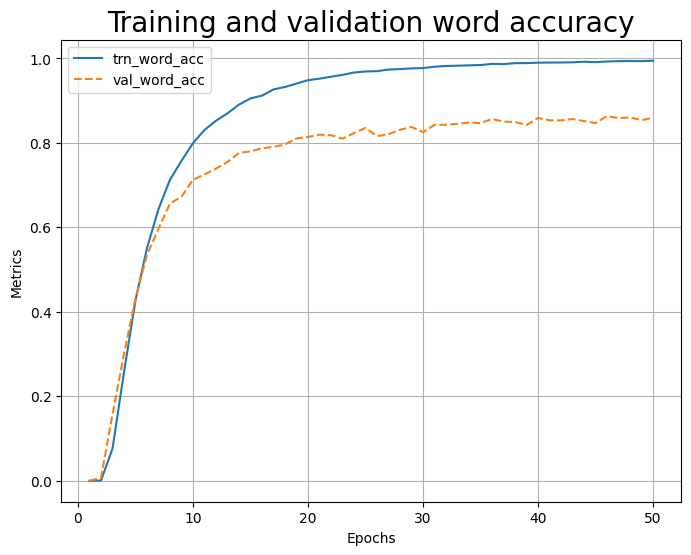

In [16]:
log.plot_epochs(['trn_word_acc','val_word_acc'], title='Training and validation word accuracy')

---